In [128]:
import os
import numpy as np
import numpy.random as rand
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import cv2 as cv
import warnings
import scipy.ndimage as nimg
import pandas as pd
import skimage as si
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import tensorflow as tf
tf.enable_eager_execution()
# from picamera import PiCamera
# from picamera.array import PiRGBArray
from tqdm.notebook import tqdm_notebook as tqdm, tnrange
from jupyterthemes import jtplot

In [88]:
%matplotlib inline
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## PiCam end

In [ ]:
camera = PiCamera()

In [15]:
camera.resolution = (1920, 1080)
camera.framerate = 15
camera.iso = 800
camera.shutter_speed = int(1/15 * 1e6)
rawCapture = PiRGBArray(camera, size=camera.resolution)
time.sleep(0.2)
for frame in camera.capture_continuous(rawCapture, format='bgr', use_video_port=True):
    image = frame.array
    cv.imshow('image', image)
    key = cv.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    
    if key == ord('s'):
        cv.imwrite('double-0.04-0.50.png', image)
    if key == ord('q'):
        break
cv.destroyAllWindows()

In [35]:
cap = cv.VideoCapture('darkframe-iso800-30fps.h264')
count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if count == 0:
            dark = np.zeros_like(frame, float)
        if count >= 200:
            dark += frame
        count += 1
    else:
        break
dark /= 250
dark /= dark.max()
dark *= 255
dark = np.uint8(dark)
cap.release()
cv.imwrite('darkframe-iso800-30fps.png', dark)

True

## Computer end

In [218]:
class ApertureSimulator:
    def __init__(self, resolution):
        if len(resolution) == 2:
            self.h, self.w = resolution
        elif len(resolution) == 1:
            self.h, self.w = *resolution, *resolution
        else:
            raise TypeError('resolution must be a tuple')
            
    def doubleSlit(self,
                   slit_width, 
                   slit_length, 
                   slit_separation,
                   hold='off',
                   savename=None):
        h, w = self.h, self.w
        slit_wid = slit_width
        slit_len = slit_length
        slit_sep = slit_separation
        
        plt.figure(figsize=(5*2, 5))

        plt.subplot(121)
        ape = np.zeros((h, w))
        ape[h//2-slit_len//2 : h//2+slit_len//2+1, 
            w//2-slit_sep//2-slit_wid//2 : w//2-slit_sep//2+slit_wid//2] = 1
        ape[h//2-slit_len//2 : h//2+slit_len//2+1, 
            w//2+slit_sep//2-slit_wid//2 : w//2+slit_sep//2+slit_wid//2] = 1
        plt.imshow(ape, 'gray')
        plt.axis('off')

        plt.subplot(122)
        FA = fft.fft2(ape)
        ape_disp = abs(fft.fftshift(FA))
        plt.imshow(ape_disp, 'gray')
        plt.axis('off')

        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()
            
        self.aperture = ape
        self.pattern = ape_disp
        
    def singleSlit(self,
                   slit_width, 
                   slit_length,
                   hold='off',
                   center=None,
                   savename=None):
        h, w = self.h, self.w
        slit_wid = slit_width
        slit_len = slit_length
        
        plt.figure(figsize=(5*2, 5))

        plt.subplot(121)
        ape = np.zeros((h, w))
        ape[h//2-slit_len//2 : h//2+slit_len//2+1, w//2-slit_wid//2 : w//2+slit_wid//2] = 1
        plt.imshow(ape, 'gray')
        plt.axis('off')

        plt.subplot(122)
        FA = fft.fft2(ape)
        ape_disp = abs(fft.fftshift(FA))
        plt.imshow(ape_disp, 'gray')
        plt.axis('off')

        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()
            
        self.aperture = ape
        self.pattern = ape_disp
        
    def square(self, length, hold='off', savename=None):
        h, w = self.h, self.w
        
        plt.figure(figsize=(5*2, 5))

        plt.subplot(121)
        r = length//2
        L = np.zeros((self.h, self.w))
        L[N//2-r:N//2+r+1, N//2-r:N//2+r+1] = 1
        plt.imshow(L, 'gray')
        plt.grid(0)
        plt.axis('off')

        plt.subplot(122)
        ape_disp = abs(fft.fftshift(fft.fft2(L)))
        plt.imshow(ape_disp, 'gray')
        plt.grid(0)
        plt.axis('off')
        
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()
            
        self.aperture = L
        self.pattern = ape_disp

In [420]:
class ApertureEstimator:
    def __init__(self, diff_pattern, dark_frame=None):
        self.diff_pattern = self._parse_input_images(diff_pattern)
        if dark_frame is not None:
            self.dark_frame = self._parse_input_images(dark_frame)
            if self.dark_frame.shape != self.diff_pattern.shape:
                self.dark_frame = cv.resize(self.dark_frame, self.diff_pattern.shape[::-1])
            self.diff_pattern -= self.dark_frame

    def _parse_input_images(self, parsee):
        if isinstance(parsee, str):
            self.filename = parsee
            return cv.imread(parsee, 0)
        elif isinstance(parsee, np.ndarray):
            return parsee
        else:
            raise TypeError('Input must be a filename or numpy array.')
            
    def showPattern(self, savename=None):
        plt.imshow(self.diff_pattern, 'gray')
        plt.grid(0)
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        
    def estimateAperture(self, logscale=False, logbase=10, hold='off', savename=None):
        self.aperture = fft.fft2(self.diff_pattern)
        if logscale:
            if logbase == 10:
                log = np.log10
            elif logbase == 2:
                log = np.log2
            elif logbase == 'e':
                log = np.log
            else:
                raise ValueError('base must be 2, 10, or `e`')
            self.aperture_display = abs(log(fft.fftshift(self.aperture)))
            plt.imshow(self.aperture_display, 'gray')
        else:
            self.aperture_display = abs(fft.fftshift(self.aperture))
            plt.imshow(self.aperture_display, 'gray')
        plt.grid(0)
#         plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()
            
    def phaseRetrievalGS(self, maxiters=1000, use_gpu=True):
        if use_gpu:
            diff = tf.convert_to_tensor(self.diff_pattern, tf.complex128)
            phase_src = tf.cast(tf.random.uniform(tf.shape(diff)), tf.complex128)
            phase_dst = tf.ones(tf.shape(diff), tf.complex128)
            j = tf.constant(1j)
            amp_src = tf.sqrt(diff)
            amp_dst = tf.ones(tf.shape(diff), tf.complex128)
            sig_src = amp_src * tf.exp(j*phase_src)
            for i in tnrange(maxiters):
                sig_dst = tf.signal.fft2d(sig_src)
                phase_dst = tf.cast(tf.angle(sig_dst), tf.complex128)
                sig_dst = amp_dst * tf.exp(j*phase_dst)
                sig_src = tf.signal.ifft2d(sig_dst)
                phase_src = tf.cast(tf.angle(sig_src), tf.complex128)
                sig_src = amp_src * tf.exp(j*phase_src)
            phase = phase_dst
            sig = tf.signal.ifft2d(tf.exp(j*phase))
            self.GS_phase = phase.numpy()
            self.GS_sig = sig.numpy()
        else:
            diff = self.diff_pattern
            phase_src = rand.random(diff.shape)
            phase_dst = np.ones(diff.shape)
            amp_src = np.sqrt(diff)
            amp_dst = np.ones(diff.shape)
            sig_src = amp_src * np.exp(1j*phase_src)
            for i in range(maxiters):
                sig_dst = fft.fft2(sig_src)
                phase_dst = np.angle(sig_dst)
                sig_dst = amp_dst * np.exp(1j*phase_dst)
                sig_src = fft.ifft2(sig_dst)
                phase_src = np.angle(sig_src)
                sig_src = amp_src * np.exp(1j*phase_src)
            phase = phase_dst
            sig = fft.ifft2(np.exp(1j*phase))
            self.GS_phase = phase
            self.GS_sig = sig
            
    def phaseRetrievalHIO(self, beta=0.9, maxiters=100, use_gpu=True):
        if use_gpu:
            diff = tf.convert_to_tensor(self.diff_pattern, tf.complex128)
            init_phase = tf.cast(tf.random.uniform(tf.shape(diff)), tf.complex128)
            j = tf.constant(1j)
            guess = diff * tf.exp(j*init_phase*2*np.pi)
            for k in tnrange(maxiters):
                init_phase = tf.cast(tf.angle(guess), tf.complex128)
                update = diff * tf.exp(j*init_phase)
                inv = tf.signal.ifft2d(update)
                inv = tf.real(inv)
                if k == 0:
                    prev = inv
                temp = inv
                inv = inv.numpy()
                prev = prev.numpy()
                for i in range(inv.size):
                    inv.flat[i] = prev.flat[i] - beta*inv.flat[i] if inv.flat[i] < 0 else inv.flat[i]
                inv = tf.convert_to_tensor(inv)
                prev = temp
                guess = tf.signal.fft2d(tf.cast(inv, tf.complex128))
            self.HIO_phase = prev.numpy()
            self.HIO_sig = guess.numpy()
        else:
            diff = self.diff_pattern
            init_phase = rand.random(diff.shape)
            guess = diff * np.exp(1j*init_phase*2*np.pi)
            for k in tnrange(maxiters):
                init_phase = tf.angle(guess)
                update = diff * np.exp(1j*init_phase)
                inv = fft.ifft2(update)
                inv = inv.real
                if k == 0:
                    prev = inv
                temp = inv
                for i in range(inv.size):
                    inv.flat[i] = prev.flat[i] - beta*inv.flat[i] if inv.flat[i] < 0 else inv.flat[i]
                prev = temp
                guess = fft.fft2(inv)
            self.HIO_phase = prev
            self.HIO_sig = guess
            
    def diffractionFitter(self, threshold=200):
        """
        single-0.08 threshold = 205
        single-0.16 threshold = 183
        double-0.04-0.25 threshold = 180
        double-0.08-0.25 threshold = 165
        double-0.08-0.50 threshold = 155
        """
        A = self.aperture_display
        h, w = self.diff_pattern.shape
        A = ((A - A.min())/(A.max() - A.min()) * 255).astype('uint8')
        thres, out = cv.threshold(A, threshold, 255, cv.THRESH_BINARY)
        blob = si.measure.label(out)
        props = si.measure.regionprops(blob, coordinates='xy')
        num_props = len(props)
        prop_names = pd.Series(props[0])
        prop_vals = np.zeros((len(prop_names), num_props), object)
        for i in range(len(prop_names)):
            for j in range(num_props):
                prop_vals[i,j] = props[j][prop_names[i]]
        props_df = pd.DataFrame(data=prop_vals.T, columns=prop_names)
        props_df = props_df.sort_values(by=['bbox_area'], ascending=False)
        slit_len = props_df['major_axis_length'].values
        slit_wid = props_df['minor_axis_length'].values
        slit_center = props_df['centroid'].values
        L = np.zeros((h, w))
        for i in range(len(slit_len)):
            if len(slit_len) >= 3:
                if i == 0:
                    continue
                if i == 3:
                    break
            cy, cx = np.int_(slit_center[i])
            sl = np.int_(slit_len[i])
            sw = np.int_(slit_wid[i])
            L[cy-sl//2:cy+sl//2+1, cx-sw//2:cx+sw//2+1] = 1
        blob_ft = abs(fft.fftshift(fft.fft2(L)))
        
        self.region_props = props_df
        self.aperture_blob = L
        self.diff_blob = blob_ft
        
    def showFit(self, r=64, zoom=True):
        plt.figure(figsize=(5*1.5, 5*1.5))
        
        plt.subplot(221)
        plt.imshow(self.diff_pattern, 'gray', aspect='auto')
        plt.grid(0)
        plt.title('experimental diffraction')
        plt.axis('off')
        
        plt.subplot(222)
        plt.imshow(self.aperture_display, 'gray', aspect='auto')
        plt.grid(0)
        plt.axis('off')
        plt.title('experimental aperture')
        plt.xlim(w//2-r, w//2+r)
        plt.ylim(h//2-r, h//2+r)
        
        plt.subplot(223)
        plt.imshow(self.diff_blob, 'gray', aspect='auto')
        plt.title('estimated diffraction')
        plt.grid(0)
        plt.axis('off')
        
        plt.subplot(224)
        plt.imshow(self.aperture_blob, 'gray', aspect='auto')
        plt.title('estimated aperture')
        plt.grid(0)
        plt.axis('off')
        
        if zoom:
            plt.xlim(w//2-r, w//2+r)
            plt.ylim(h//2-r, h//2+r)
        
        plt.tight_layout()
        plt.show()

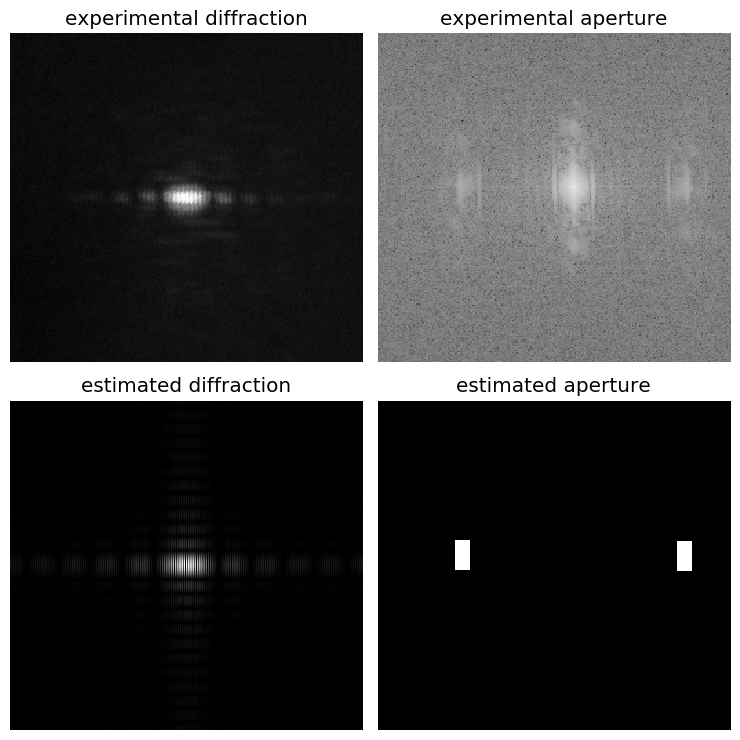

In [442]:
ae = ApertureEstimator('double-0.08-0.50.png', 'darkframe-iso800-30fps.png')
ae.estimateAperture(logscale=True, hold='on')
plt.close('all')
ae.diffractionFitter(threshold=155)
ae.showFit(r=128, zoom=True)